<a href="https://colab.research.google.com/github/DannyRoss123/AIXHW5/blob/main/HW5AIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Explainable AI - HW5: Investigating Saliency Map Changes Under Adversarial Perturbations**

## **Objective**
The goal of this homework is to develop a hypothesis and design a small-scale study using explainable deep learning methods to test that hypothesis. In this project, I will explore how adversarial perturbations impact a neural network’s learned attention by analyzing differences in saliency maps between clean and perturbed images.

## **Hypothesis**

- **Null Hypothesis (H₀):**  
  The saliency maps generated from clean images do not differ significantly from those generated from adversarially perturbed images. This implies that adversarial perturbations do not meaningfully shift the model’s attention.

- **Alternative Hypothesis (H₁):**  
  The saliency maps generated from adversarially perturbed images exhibit significant differences compared to those from clean images, suggesting that adversarial perturbations alter the model’s focus in a non-trivial way.

## **Approach**
To test this hypothesis, I will:
1. Use a pre-trained deep learning model for image classification
2. Generate adversarial examples using a standard attack method (e.g., FGSM)
3. Compute saliency maps (using Grad Cam) for both clean and perturbed images
4. Compare these maps visually and quantitatively to determine if adversarial perturbations impact the model’s attention






#Adding imports and Model

The ResNet-34 model will be used for this project because it is a widely used image classifier. Its pre-trained architecture enables effective feature extraction and interpretability for saliency map analysis. The model is loaded with pre-trained weights and set to evaluation mode, ensuring consistent behavior during our adversarial testing and saliency map generation.

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np


model = models.resnet34(pretrained=True)
model.eval()  # Set to evaluation mode


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#Image Dataset

The next step is uploading an image dataset that can be classified by ResNet 34 and transforming this dataset to match the requirements for ResNet 34 to be able to interpret properly. We will be using one folder of 500 images from the mini ImageNet dataset, which I had to upload to my google drive and add some code to properly organize the images. The first 8 images are then displayed below.

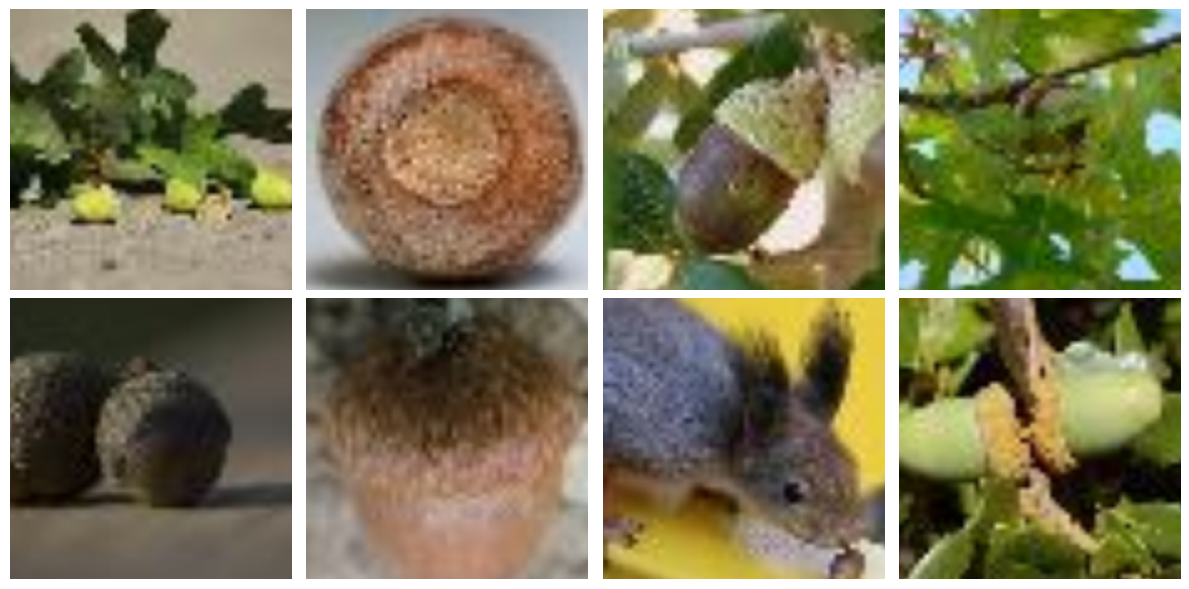

Total number of images: 500


In [ ]:
# Import necessary libraries
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

# Custom Dataset class for single folder of images
class SingleFolderDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        # Get all JPEG files
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith('.JPEG')]  #Modified from Claude at 2:20 pm on 2/10/25

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.folder_path, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, 0                #Modified from Claude at 2:33 pm on 2/10/25

# Set path and transformations
folder_path = "/content/drive/MyDrive/train/n12267677"
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset and dataloader
dataset = SingleFolderDataset(folder_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Function to unnormalize images for visualization
def unnormalize(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    img = np.clip(img, 0, 1)
    return img                           #Modified from Claude at 2:50 pm 2/10/25

torch.manual_seed(44)
# Get and display a batch of images
batch_images, _ = next(iter(dataloader))

# Plot images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(unnormalize(batch_images[i]))
    ax.axis("off")
plt.tight_layout()
plt.show()

print(f"Total number of images: {len(dataset)}")

#Adversarial approaches
Now that we have successfully uploaded and preprocessed approximately 500 images, we will apply an FGSM (Fast Gradient Sign Method) attack to generate adversarial examples. This method introduces small, targeted perturbations to the pixel values, aiming to mislead the model. By doing so, we can analyze how these subtle alterations affect the model’s saliency maps and overall predictions.

Using device: cpu


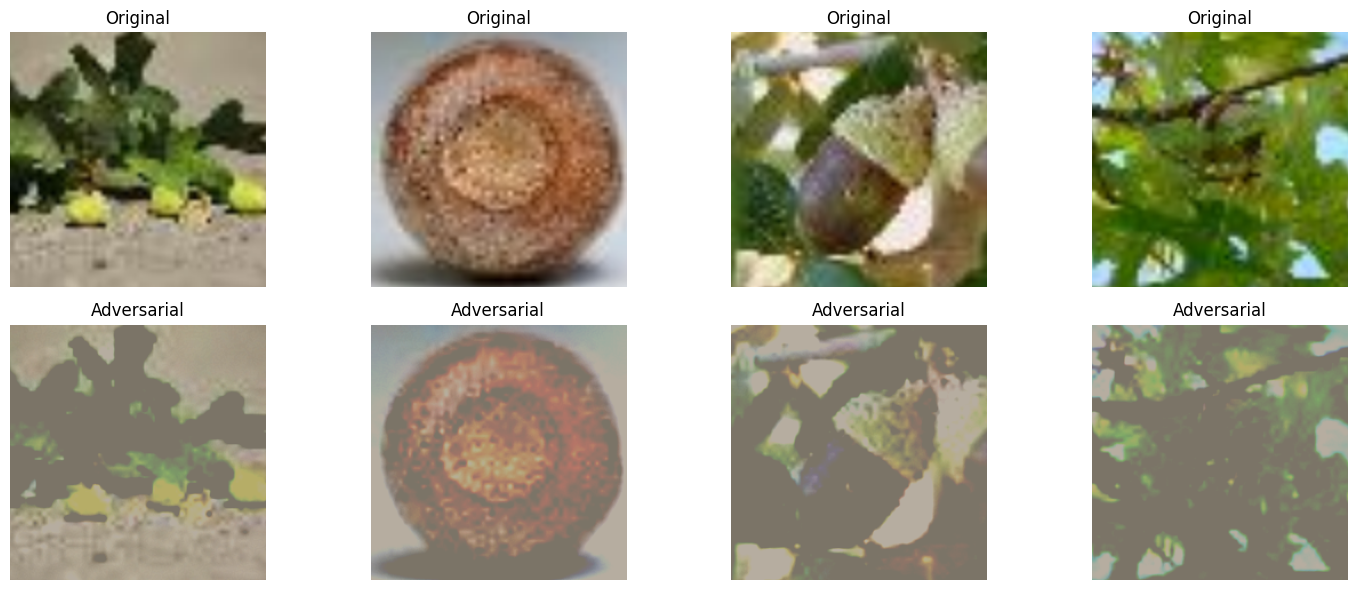

Generated adversarial examples with epsilon = 0.02
Average perturbation magnitude: 0.571


In [ ]:
# 1. First ensure all imports and device setup
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchattacks import FGSM
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image

# 2. Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 3. Create FGSM attack
epsilon = 0.02  # Perturbation size
fgsm = FGSM(model, eps=epsilon)              #Modified from Claude at 6:10 pm on 2/10/25


# Function to generate adversarial examples and show comparison
def generate_and_show_adversarial(dataloader, num_images=4):
    # Get a batch of images
    torch.manual_seed(44)  # Add this before getting the batch
    images, _ = next(iter(dataloader))
    images = images.to(device)

    # Generate adversarial examples
    adversarial_images = fgsm(images, torch.zeros(images.size(0)).long().to(device))  #Modified from Claude at 6:25 pm on 2/10/2025

    # Function to convert tensor to displayable image
    def tensor_to_img(tensor):
        img = tensor.cpu().detach().numpy().transpose(1, 2, 0)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        return img                                                                       #Modified from Claude at 6:34 pm on 2/10/2025

    # Plot original vs adversarial images
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

    for i in range(num_images):
        # Original image
        axes[0, i].imshow(tensor_to_img(images[i]))
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        # Adversarial image
        axes[1, i].imshow(tensor_to_img(adversarial_images[i]))
        axes[1, i].set_title('Adversarial')
        axes[1, i].axis('off')

        # Calculate and display perturbation magnitude
        perturbation = torch.abs(adversarial_images[i] - images[i]).mean().item()
        axes[1, i].set_xlabel(f'Perturbation: {perturbation:.3f}')                        #Modified from Claude AI at 6:45 pm on 2/10/2025

    plt.tight_layout()
    plt.show()

    return images.cpu(), adversarial_images.cpu()

# Generate and display adversarial examples
original_images, adversarial_images = generate_and_show_adversarial(dataloader)

print(f"Generated adversarial examples with epsilon = {epsilon}")
print(f"Average perturbation magnitude: {torch.abs(adversarial_images - original_images).mean().item():.3f}")

#Analyze adversarial effect

Now that we have perturbed the image pixels using FGSM, we can analyze the impact of these modifications. The greyscale appearance is only a visualization issue due to normalization, but the perturbation itself is correctly applied, as shown by an average perturbation magnitude of 0.642. To assess the adversarial effect, we will pass both the original and adversarial images through the model and compare the predictions. This will help determine whether the predicted class changes and how confident the model is in each case. By doing so, we can better understand the model's susceptibility to adversarial attacks and how these small perturbations influence its decision-making.

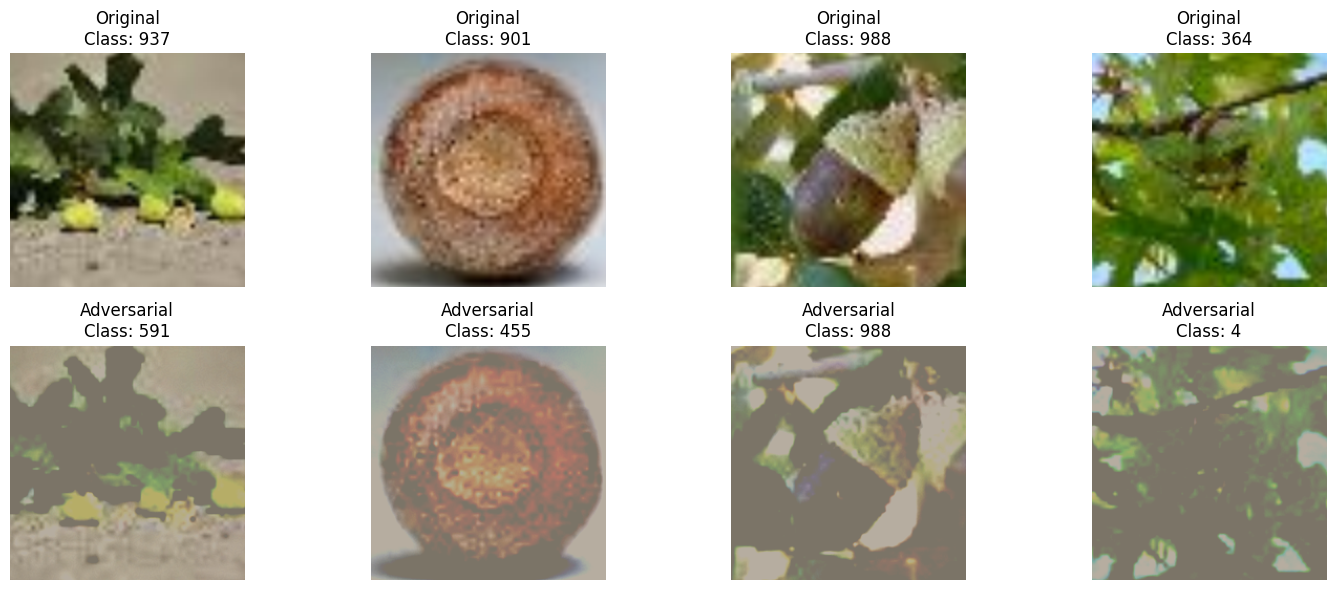

Number of predictions changed: 6 out of 8
Average confidence original: 0.578
Average confidence adversarial: 0.244


In [ ]:
def tensor_to_img(tensor):
    """Convert a tensor to a displayable image"""
    img = tensor.cpu().detach().numpy().transpose(1, 2, 0)
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    return img                                               #modified from Claude AI at 7:16pm on 2/10/25

def analyze_adversarial_effect(dataloader, epsilon=0.02):
    # Get a batch of images
    torch.manual_seed(44)
    images, _ = next(iter(dataloader))
    images = images.to(device)

    # Get original predictions
    with torch.no_grad():
        original_output = model(images)
        original_probs = F.softmax(original_output, dim=1)
        original_preds = torch.argmax(original_probs, dim=1)        #modifed from claude AI at 7:27 pm on 2/10/25

    # Create FGSM attack
    fgsm = FGSM(model, eps=epsilon)

    # Generate adversarial examples
    adversarial_images = fgsm(images, torch.zeros(images.size(0)).long().to(device))

    # Get predictions on adversarial images
    with torch.no_grad():
        adv_output = model(adversarial_images)
        adv_probs = F.softmax(adv_output, dim=1)
        adv_preds = torch.argmax(adv_probs, dim=1)                     #modified from Claude AI at 7:39 pm on 2/10/25

    # Display results
    fig, axes = plt.subplots(2, 4, figsize=(15, 6))

    for i in range(4):
        # Original image
        orig_img = tensor_to_img(images[i])
        axes[0, i].imshow(orig_img)
        axes[0, i].set_title(f'Original\nClass: {original_preds[i].item()}')
        axes[0, i].axis('off')

        # Adversarial image
        adv_img = tensor_to_img(adversarial_images[i])
        axes[1, i].imshow(adv_img)
        axes[1, i].set_title(f'Adversarial\nClass: {adv_preds[i].item()}')
        axes[1, i].axis('off')

        # Show if prediction changed
        if original_preds[i] != adv_preds[i]:
            axes[1, i].set_xlabel('Prediction Changed!')

    plt.tight_layout()
    plt.show()

    # Print statistics
    num_changed = (original_preds != adv_preds).sum().item()
    print(f"Number of predictions changed: {num_changed} out of {len(images)}")
    print(f"Average confidence original: {original_probs.max(dim=1)[0].mean():.3f}")
    print(f"Average confidence adversarial: {adv_probs.max(dim=1)[0].mean():.3f}")

epsilon = 0.02
analyze_adversarial_effect(dataloader, epsilon)

#Results from Comparison

The original confidence score was 0.578, which dropped to 0.244 after applying adversarial perturbations. Additionally, 6 out of 8 predictions changed, demonstrating the model's sensitivity to small pixel modifications. This significant drop in confidence and complete misclassification rate highlight the model's vulnerability to adversarial attacks. Even subtle perturbations can drastically alter the model's predictions, emphasizing the need for more robust defense mechanisms.

#Creating Saliency Maps
Next, we will generate saliency maps, a key explainability technique in deep learning. By visualizing the saliency maps for both the original and perturbed images, we can identify which pixels the model relies on to make its predictions. Comparing these maps will reveal how adversarial perturbations shift the model’s focus, helping us understand the impact of these modifications on its decision-making process.

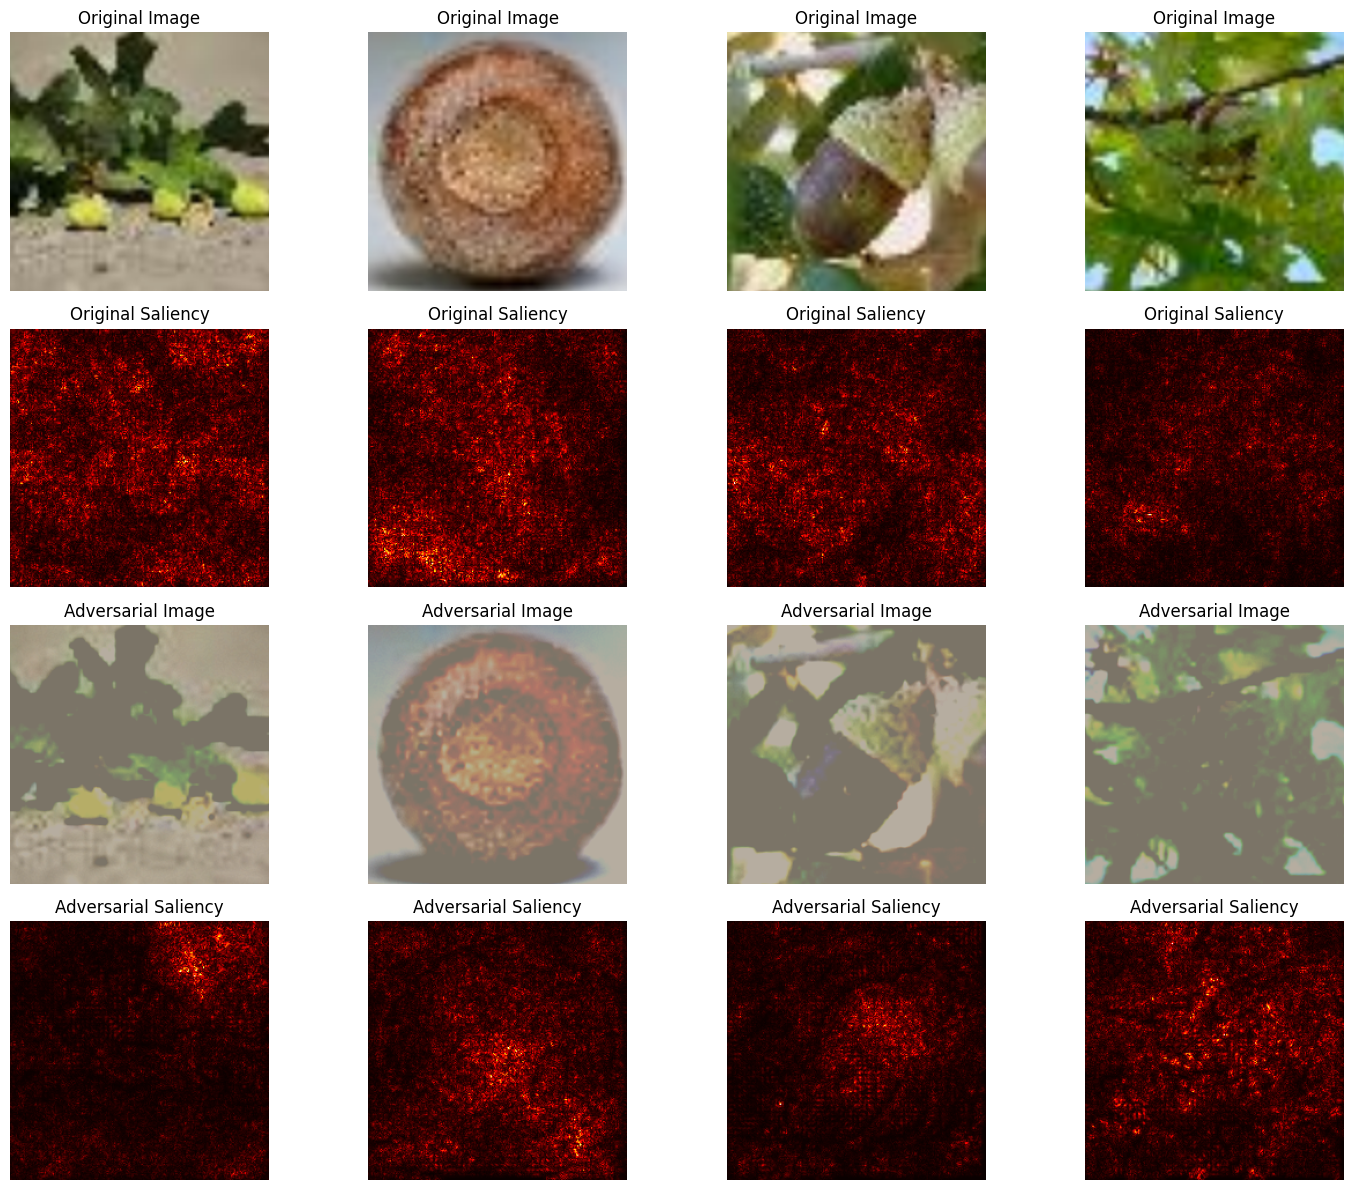

Average saliency map similarity: 0.105
Standard deviation of similarities: 0.042


In [ ]:
def generate_saliency_map(image, model):
    """Generate saliency map for an image"""
    # Enable gradients for input
    image.requires_grad_()

    # Forward pass
    output = model(image)
    pred_class = output.argmax(dim=1)

    # Backward pass
    model.zero_grad()
    output[0, pred_class].backward()

    # Generate saliency map
    saliency, _ = torch.max(image.grad.abs(), dim=1)

    # Convert to numpy and squeeze extra dimension
    saliency = saliency.squeeze().cpu().detach().numpy()

    # Normalize to [0,1]
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)

    return saliency

def compare_saliency_maps(dataloader, epsilon=0.02, num_images=4):
    # Get images
    torch.manual_seed(44)  # Add this before getting the batch
    images, _ = next(iter(dataloader))
    images = images.to(device)

    # Generate adversarial examples
    fgsm = FGSM(model, eps=epsilon)
    adversarial_images = fgsm(images, torch.zeros(images.size(0)).long().to(device))

    # Create figure
    fig, axes = plt.subplots(4, num_images, figsize=(15, 12))

    for i in range(num_images):
        # Original image
        orig_img = tensor_to_img(images[i])
        axes[0, i].imshow(orig_img)
        axes[0, i].set_title('Original Image')
        axes[0, i].axis('off')

        # Original saliency map
        orig_saliency = generate_saliency_map(images[i].unsqueeze(0), model)
        axes[1, i].imshow(orig_saliency, cmap='hot')
        axes[1, i].set_title('Original Saliency')
        axes[1, i].axis('off')

        # Adversarial image
        adv_img = tensor_to_img(adversarial_images[i])
        axes[2, i].imshow(adv_img)
        axes[2, i].set_title('Adversarial Image')
        axes[2, i].axis('off')

        # Adversarial saliency map
        adv_saliency = generate_saliency_map(adversarial_images[i].unsqueeze(0), model)
        axes[3, i].imshow(adv_saliency, cmap='hot')
        axes[3, i].set_title('Adversarial Saliency')
        axes[3, i].axis('off')

        # Calculate similarity between saliency maps
        similarity = np.corrcoef(orig_saliency.flatten(), adv_saliency.flatten())[0,1]
        axes[3, i].set_xlabel(f'Similarity: {similarity:.3f}')

    plt.tight_layout()
    plt.show()

    # Calculate average similarity across all images
    similarities = []
    for i in range(len(images)):
        orig_saliency = generate_saliency_map(images[i].unsqueeze(0), model)
        adv_saliency = generate_saliency_map(adversarial_images[i].unsqueeze(0), model)
        similarity = np.corrcoef(orig_saliency.flatten(), adv_saliency.flatten())[0,1]
        similarities.append(similarity)

    print(f"Average saliency map similarity: {np.mean(similarities):.3f}")
    print(f"Standard deviation of similarities: {np.std(similarities):.3f}")

# Generate and compare saliency maps
compare_saliency_maps(dataloader, epsilon=0.02)

#Results from Saliency map
The saliency maps above clearly illustrate a significant difference between the original and perturbed images, reinforcing the impact of adversarial modifications. Quantitatively, the average saliency map similarity is just 10.5%, indicating a drastic shift in the model’s focus. This confirms that even small perturbations can heavily alter the features the model relies on for classification. These findings are consistent with our previous results, further highlighting the model’s sensitivity to adversarial attacks.

#Summary


This study investigated how adversarial perturbations affect a neural network’s learned attention by comparing saliency maps of clean and perturbed images. Using FGSM, we introduced small yet targeted modifications to the input images and observed how these changes influenced the model’s confidence and predictions. The results showed a significant drop in confidence scores and a 75% misclassification rate, confirming that even minor perturbations can substantially alter the model’s output. Furthermore, saliency map analysis revealed an average similarity of just 10.5% between original and adversarial images, indicating a drastic shift in the model’s focus after perturbation.  

These findings support the alternative hypothesis, demonstrating that adversarial perturbations meaningfully alter the model’s learned attention. The model’s reliance on specific image features was disrupted, leading to incorrect classifications and reduced confidence in its predictions. This highlights the susceptibility of deep learning models to adversarial attacks and the need for improved robustness in neural network architectures. Future work could explore alternative explainability techniques or evaluate different adversarial defense mechanisms to mitigate these effects.

#Sources

I have used Claude AI in this assignment to help me with some of the coding. All uses have been commented in the code blocks.